In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

cuda


In [3]:
def real_fn(x):
    return x*x + 3*x + 2


def get_real_samples(n=5000, r=50):
    data = []
    x = r * randn(n)

    for i in range(n):
        y = real_fn(x[i])
        data.append([x[i], y])

    return torch.FloatTensor(data)

In [4]:
def get_fake_samples(n=5000, elements=5):
    return torch.randn(size=[n, elements])

In [5]:
class Generator(nn.Module):
    def __init__(self, input_len=5, hidden_len=16, output_len=2):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_len, hidden_len),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_len, hidden_len),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_len, output_len)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


generator = Generator()

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_len=2, hidden_len=16, output_len=1):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_len, hidden_len),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_len, hidden_len),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_len, output_len),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


discriminator = Discriminator()

In [7]:
d_lr = 2e-3
g_lr = 2e-3

In [8]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr)
g_optimizer = optim.Adam(generator.parameters(), lr=g_lr)

In [9]:
loss = nn.BCELoss()

In [10]:
dtype = torch.cuda.FloatTensor

def ones_target(size):
    data = Variable(torch.ones(size, 1).type(dtype))
    return data


def zeros_target(size):
    data = Variable(torch.zeros(size, 1).type(dtype))
    return data

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)

    error = loss(prediction, ones_target(N))
    error.backward()

    optimizer.step()

    return error

In [13]:
num_test_samples = 256
discriminator_steps = 20
generator_steps = 20
num_epochs = 2000
epoch_printing = 100
discriminator.to(device)
generator.to(device)

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [14]:
def current_status(real, fake):
    x, y = zip(*fake.tolist())
    plt.scatter(x, y)
    x, y = zip(*real.tolist())
    plt.scatter(x, y)
    plt.legend(['Generated Data', 'Real Data'], loc='upper left')
    plt.show()

Epoch
1900
Discriminator Loss:
tensor(1.3783, device='cuda:0', grad_fn=<AddBackward0>)
Generator Loss:
tensor(0.6749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


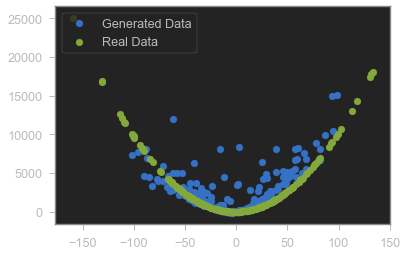

In [15]:
for epoch in range(num_epochs):
    real_plot_data = None
    fake_plot_data = None
    
    for d_steps in range(discriminator_steps):
        real_data = get_real_samples(n=num_test_samples)
        real_plot_data = real_data
        fake = get_fake_samples(n=num_test_samples)
        fake = fake.to(device)
        fake_data = generator(fake).detach()
        fake_data = fake_data.to(device)
        real_data = real_data.to(device)
        d_error, d_pred_real, d_pred_fake = \
            train_discriminator(
                d_optimizer, real_data, fake_data)
    
    for g_steps in range(generator_steps):
        fake = get_fake_samples(n=num_test_samples)
        fake = fake.to(device)
        fake_data = generator(fake)
        fake_plot_data = fake_data
        g_error = train_generator(g_optimizer, fake_data)
    
    if(epoch % epoch_printing == 0):
        clear_output()
        print("Epoch")
        print(epoch)
        print("Discriminator Loss:")
        print(d_error)
        print("Generator Loss:")
        print(g_error)
        current_status(real_plot_data, fake_plot_data)

In [16]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
torch.save(g_optimizer.state_dict(), 'g_optimizer.pth')
torch.save(d_optimizer.state_dict(), 'd_optimizer.pth')